# Symbolisches Rechnen

Bisher haben wir uns auf den *numerischen* Teil konzentriert; d.h. das Ausrechnen von Werten. Mit Python können wir allerdings auch *symbolisches Rechnen* durchführen, also das Bearbeiten von symbolischen Ausdrücken (Computer Algebra System (CAS)).

CAS sind keine Alleskönner, können aber eine signifikante Hilfe sein. In der Kombination mit numerischer Berechnung kann hat man mächtige Werkzeuge zur Verfügung.

Wir benutzen hierfür eine Kombination aus den Modulen  **SymPy** und **Theano**.

## Einfache Ausdrücke

Man muss erstmal die Symbole Python bekannt machen, um damit etwas tun zu können. Das passiert mit:

``` python
sympy.symbols(varliste)
```

Die Funktion erzeugt die in einer String-Liste angegebenen Variablen als Symbole und gibt diese zurück. Dann kann man via *pattern matching* diesen normale Variablennamen geben.

*Beispiel:* Wir erzeugen die mathematischen Symbole $x$ und $y$ und geben ihnen die Namen ```x``` und  ```y```

In [1]:
from sympy import symbols

x,y = symbols('x,y')

Jetzt erzeugen wir unseren ersten Ausdruck. Dafür importieren wir in diesem Beispiel auch eine Funktion (exp) aus SymPy.

*Vorsicht:* das ist eine andere Funktion als die aus `numpy`.

In [1]:
from sympy import exp
expr = exp(x) + 1
expr

exp(x) + 1

Das ist jetzt ein mathematischer Ausdruck in dem wir z.B. Substituieren können:

```python
expr_object.subs(varname,value)
```
substituiert die *varname* mit *value*.


In [1]:
expr.subs(x,1)

1 + E

In SymPy kann man auch schönen mathematischen Formelsatz zur Darstellung verwenden (durch $\LaTeX$). Dafür brauchen wir

In [1]:
from sympy.interactive import printing
printing.init_printing(use_latex=True)

Dann werden die Ausdrücke mittels $\LaTeX$ gerendert und eben einfach *schön* dargestellt.

In [1]:
expr

Ausdrücke können auch direkt über strings erzeugt werden

``` python
sympy.sympify(ausdruckstring)
```

- `ausdruckstring`:  ein String eines mathematischen Ausdrucks. Variablen die darin vorkommen werden automatisch als solche erzeugt. 

In [1]:
from sympy import sympify

expr = sympify("x**2 + exp(x)")
expr.subs(x,2)

### Vereinfachungen

Die mit häufigste Operation auf symbolischen Ausdrücken ist deren *Vereinfachung*. 

```python
expr_object.simplify()
```

*Hinweis:* Es werden alle möglichen Vereinfachungen angewandt; es ist nicht eindeutig was am Einfachsten ist, daher kann sein, dass die Funktion nicht das macht, was man erwartet.

In [1]:
from sympy import sin, cos
(sin(x)**2 + cos(x)**2).simplify()

### Operatoren und Operanden - der Abstract Syntax Tree (AST)

Ausdrücke in ihre Operatoren und Operanden aufteilen ist eine Basis-Funktionalität im symbolischen Rechnen. 
Dafür wird ein Syntax-Baum aufgebaut, deren Knoten und Blätter bestehen aus Operatoren und Operanden.

Das Auseinandernehmen in einen String erledigt 

``` python
srepr(expr)
```


In [1]:
from sympy import srepr
srepr(expr)

"Add(Pow(Symbol('x'), Integer(2)), exp(Symbol('x')))"

Nun wollen wir das aber nicht nur "Lesen" sondern auch programmatisch weiterverarbeiten. 
Jeder Ausdruck stellt dafür eine Objektvariable zur Verfügung, die die Argumente (Operatoren und Operanden) enthält. 

``` python
expr.args
```

Wir schreiben uns eine kleine rekursive Funktion um durch den Baum durchzugehen

In [1]:
def traverse(expr):
    print(expr)
    for arg in expr.args:
        traverse(arg)
traverse(expr)

x**2 + exp(x)
x**2
x
2
exp(x)
x


Es gibt auch bereits eine vorgefertigte Funktion, die durch den Baum geht und einen entsprechenden Iterator zurückgibt.

``` python
preorder_traversal(expr)
```


In [1]:
from sympy import preorder_traversal
for arg in preorder_traversal(expr):
    print(arg)

x**2 + exp(x)
x**2
x
2
exp(x)
x


Mit dem gelernten graph-tool können wir hier den Baum als Graph darstellen. 

In [1]:
from graph_tool import Graph

def stringify_expr(expr):
    if expr.args:
        # Ausdruck hat Argumente => Funktion oder ähnliches
        return expr.func.__name__
    elif expr.is_Symbol:
        return 'Sym({})'.format(expr.name)
    else:
        # Andere Ausdrücke (z.B. Zahlen) direkt zurückgeben
        return str(expr)

def expr_to_graph(expr):
    g = Graph()
    v_name = g.new_vertex_property("string")
    g.vertex_properties['name'] = v_name
    
    def traverse(ex):
        # Walk erzeugt den Graphen für den Ausdruck `ex` und gibt den root-node
        # zurück. Die Funktion ruft sich dabei rekursiv selbst auf.
        root = g.add_vertex()
        v_name[root] = stringify_expr(ex)
        for arg in ex.args:
            v = traverse(arg)
            g.add_edge(root, v)
        return root
    
    traverse(expr)
    return g

In [1]:
from sympy import sympify
expr = sympify("x**2 + exp(x)")
g = expr_to_graph(expr)

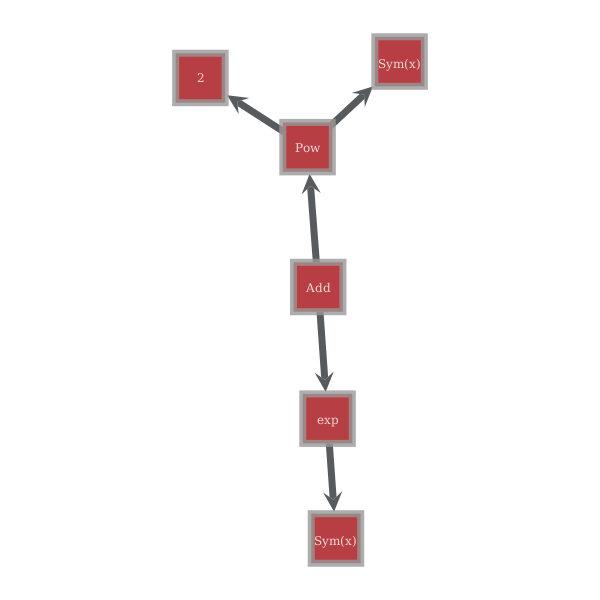

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f44a8ff29e8, at 0x7f446fe60c50>

In [1]:
from graph_tool.draw import graph_draw
graph_draw(g, 
           vertex_text=g.vertex_properties['name'], 
           vertex_font_size=12,
           vertex_shape='square',
           edge_marker_size=20)

Weitere Vereinfachungs-Funktionen findet man in der Dokumentation. Wir gehen nicht weit auf dieses Thema ein, da unser Fokus auf der Programmierung im wissenschaftlichen Rechnen liegt.

## Polynome

Polynome sind der Kern der Computer-Algebra. 

``` python
sympy.poly(expr)
```

- `expr`: Ausdruck

*Beispiel:* Erzeugung eines Polynom-Objektes:

In [1]:
from sympy import poly
expr = x**2 + 4*x**3 + x + 5
a = poly(expr)

Das Objekt hat jetzt eine Reiher spezieller Eigenschaften

``` python
poly_object.coeffs()
```

gibt die Koeffizienten des Polynoms in der Form

$$f(x) = a_0 x^n + a_1 x^{n-1} + \dots  + a_i x^{n-i}, i = 0..n$$

wobei $n$ der Grad des Polynoms ist


In [1]:
a.coeffs()

Grad des Polynoms

In [1]:
a.degree()

Polynom-Objekte haben noch einige weitere (zusätzliche) Eigenschaften im Vergleich zu einfachen Ausdrücken uns reicht hier aber schon die paar Befehle.

#### Nullstellen bestimmen und Gleichungen lösen

``` python
sympy.solve(expr_object, x)
```

- `expr_object`: Ausdrucks-Objekt
- `x`: löst bzgl. der Variablen $x$

löst eine Gleichung

``` python
sympy.roots(expr_object)
```

findet Nullstellen


In [1]:
from sympy import roots,solve

null = solve(expr, x)
null

Das sind jetzt zwar schöne mathematische und exakte Ausdrücke, aber manchmal bin ich nur an harten Zahlen interessiert. 

#### Numerische Auswertung von Funktionen und Ausdrücken

Es gibt mehrere Möglichkeiten für die Auswertung von symbolischen Ausdrücken. Mit *subs()* haben wir einen Teil davon bereits erledigen: Wir können Variablen durch Zahlen (oder andere Variablen ersetzen). 

Wollen wir jetzt eine numerische Auswertung gegebener Präzision, nutzen wir dafür 

``` python
expr_object.evalf(n)
```

- **n**: Genauigkeit in Nachkommastellen.



In [1]:
expr2 = sympify("x**2 + exp(x)")
expr2.subs(x,2).evalf(100)

Das können wir jetzt nutzen um die Nullstellen als einfache Zahl zu bekommen

In [1]:
[x.evalf() for x in null]

In [1]:
roots(expr)

### Grenzwerte

das symbolische Bestimmen von Grenzwerten kann man mit

``` python
expr_objekt.limit(var, grenze)
```

- `var`: variablenname
- `grenze`: Ort an dem geprüft werden soll. Kann auch *unendlich* (```oo```) sein.

Als *unendlich* kann das Symbol `oo` benutzt werden:

``` python
from sympy import oo
```

In [1]:
(sin(x)/x).limit(x,0)

In [1]:
from sympy import oo
(sin(x)/x).limit(x,oo)

### Differentation 

``` python
expr_object.diff(var1, var2, ..)
```
Leitet das entsprechende Objekt nach der gegebenen Variable ab. Mehrere Angabe von Variablen führt zu mehrmaligen Ableiten in der gegebenen Reihenfolge.


In [1]:
expr.diff()

In [1]:
expr.diff(x,x)

#### Taylorformel
Sei $f:I \rightarrow \mathbb{R}$ $(n+1)$-mal differenzierbar und seien $x,x_0 \in I$, $x \neq x_0$. Dann gibt es $\xi \in \mathbb{R}$, so dass  
$$f(x) = f(x_0) + \frac{f\,'(x_0)}{1!}(x-x_0)+\frac{f\,''(x_0)}{2!}(x-x_0)^2 + \cdots + \frac{f^{\,n}(x_0)}{n!}(x-x_0)^n +R_n(x,x_0)$$ gilt mit dem Lagrangschen Restglied $$R_n(x,x_0) := \frac{f^{\,(n+1)}(\xi)}{(n+1)!} (x-x_0)^{n+1}.$$ 

Taylorpolynom $(n)$-ten Grades zu einem Ausdruck $f$ (mit Unbekannten $x$) am Entwicklungspunkt $x0$.  

``` python
expr_object.series(expr, x, x0, n)
```
- `expr`: Ausdruck
- `x`: Variable um die entwickelt werden soll
- `x0`: Entwicklungspunkt
- `n`: Anzahl Glieder



In [1]:
exp(x).series(x,0,4)

###  Integration

unbestimmtes Integral

``` python
expr_object.integrate(args)
```
- `args` : Integrationsvariablen 

bestimmtes Integral

``` python
expr_object.integrate(tripel)
```
- `tripel` : (Integrationsvariable, untere Schranke, obere Schranke)





In [1]:
expr.integrate()

In [1]:
from sympy import oo
expr.integrate((x, 0, oo))

### Matrizen 

Hier nutzen wir 

``` python
sympy.Matrix(liste)
```
- `liste`: einfache oder doppelt verkettete Liste von Einträgen entsprechend der Ausgabe- Dimension


In [1]:
from sympy import Matrix, cos, sin

rho, phi = symbols ('rho,phi')
Matrix([[rho*cos(phi), rho*sin(phi), rho**2],[ cos(phi), sin(phi), rho]])

### höherdimensionale Funktionen

Mit Matrizen kann man jetzt höherdimensionale Funktionen geeignet nutzen

*Beispiel:* 
$f: \mathbb{R}^2 \rightarrow \mathbb{R}^3$
$$ f(\rho, \phi) = \left( \begin{array}{c} 
\rho \cos(\phi)\\ \rho \sin(\phi) \\ \rho^2 \end{array}\right) $$

In [1]:
from sympy import Matrix, cos, sin

rho, phi = symbols ('rho,phi')
X = Matrix([rho*cos(phi), rho*sin(phi), rho**2])
X

Hier funktionieren jetzt z.B. substituieren, differenzieren, usw. wie bei einfachen Ausdrücken

In [1]:
X.subs(rho, 4), X.diff(rho)

Alle partiellen Ableitungen bzgl. $\rho$ und $\phi$ (Jacobi-Matrix)

In [1]:
Y = (rho, phi)
X.jacobian(Y)

## Effiziente umfangreichere numerische Berechnung

Umfangreichere Berechnungen sind typischerweise in begrenzter Präzision (aufgrund des Speicherplatz-Bedarfs).
Die effizienteste Variante ist die Nutzung von **Theano**

``` python 
sympy.printing.theanocode.theano_function(inputs, outputs, dims=dictofdims)
```

- `inputs`: Liste der Variablen
- `outputs`: Liste der Funktionen/Ausdrücke
- `dictofdims`: Dictionary; Variablen als Keys und Dimensgrößen als Werte

In [1]:
x,y = symbols('x,y')
expr = exp(x) + x**2
expr

In [1]:
from sympy.printing.theanocode import theano_function

f = theano_function([x], [expr], dims={x: 0})

*f* ist jetzt eine normale auswertbare Funktion die *arrays* zurückgibt.

In [1]:
f(4)

Eine der Stärken von Theano ist es z.B. Funktion und ihre Ableitung gleichzeitig sehr effizient auszurechnen. 

In [1]:
outputs = expr, expr.diff(x)
f = theano_function([x], outputs, dims={x: 0})

In [1]:
f(4)

#### Ableitung Funktion mehrer Veränderlicher: Jacobi-Matrix


In [1]:
from sympy import Matrix, cos, sin

rho, phi = symbols ('rho,phi')
X = Matrix([rho*cos(phi), rho*sin(phi), rho**2])
Y = (rho, phi)
X.jacobian(Y)

In [1]:
f = theano_function([rho,phi],[X, X.jacobian(Y)])

In [1]:
f(4,4)

## Primzahlen

Wir schauen uns hier nur Funktionalität im Zusammenhang mit Primzahlen an.

Ein Algorithmus zur Erzeugung von Primzahlen ist z.B. der *Sieve von Eratosthenes* 

``` python
sympy.sieve
```

Das ist eine unendliche Liste aller Primzahlen. Es wird aber nur soviel berechnet wie gebraucht wird.


In [1]:
from sympy import sieve

25 in sieve

``` python
sympy.primerange(a,b)
```
gibt alle Primzahlen im Bereich von $a$ bis $b$ als Generator wieder.


In [1]:
from sympy import primerange

In [1]:
list(primerange(10,30))

``` python
sympy.isprime(number)
```
Testet die gegebene Zahl, ob sie eine Primzahl ist und gibt entsprechend ```True``` oder ```False``` zurück


In [1]:
from sympy import isprime
isprime(29)